# Proyecto 1 - Grupo 9

## Integrantes
* Carol Sofía Florido Castro - 202111430
* Juan Martin Vasquez Cristancho - 202113314 
* Natalia Villegas Calderon - 202113370


## Objetivo

* Aplicar la metodología de analítica de textos para la construcción de soluciones de analítica alineadas con los objetivos de organizaciones en un contexto de aplicación

## Caso de Negocio: Noticias falsas en la política

La divulgación de noticias falsas sobre política a nivel nacional e internacional es una amenaza que puede impactar la gobernabilidad de países y la seguridad global. A nivel
interno de un país puede generar polarización y manipulación de la opinión pública debilitando la confianza en instituciones democráticas. Esto puede llevar a influir en elecciones,
justificar medidas impopulares entre otras consecuencias. A nivel internacional, estas noticias pueden generar tensiones diplomáticas, influir en decisiones de política exterior y
ser usadas en campañas de desestabilización por parte de gobiernos o grupos específicos. Esta reflexión motivó a un grupo de académicos a recolectar y generar noticias con el fin
de utilizar aprendizaje automático para facilitar la detección de noticias falsas. Este conjunto de datos es el que se va a utilizar en el contexto de este proyecto y está disponible en
la sección de Bloque Neón de la sección unificada del curso

## Los datos


Se trabaja con un conjunto de datos que contiene 57,063 registros de noticias. Cada registro incluye su titulo, descripcion, fecha de publicacion y la etiqueta que indica 0 si la noticia es falsa o 1 que es verídica.

# 1. Carga de los datos y manipulación básica de los datos

In [59]:
%pip install -U imbalanced-learn


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Limpieza de datos

In [2]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, r2_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

# Importaciones de joblib
from joblib import dump, load

# Importaciones de nltk
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer, SnowballStemmer


# Instalación de paquetes adicionales
%pip install contractions
import contractions

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV

# Para la validación cruzada
from sklearn.model_selection import KFold

# Clasificacion
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Cargar datos
file_path = 'fake_news_spanish.csv'
df = pd.read_csv(file_path, delimiter=';', encoding='utf-8')


Se evidencia que el dataset de entrenamiento presenta 57063 registros y 5 columnas o atributos.

In [4]:
df.shape

(57063, 5)

Se observa una muestra de datos

In [5]:
df.head()


,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


Se observan los tipos de datos cargados, los cuales tienen sentido con la descripción de los datos. Es importante considerar que aunque el label es un entero, este representa una variable categórica.

In [6]:
df.dtypes

ID             object
Label           int64
Titulo         object
Descripcion    object
Fecha          object
dtype: object

Como se evidencia la fecha esta siendo reconocida como objeto, por lo que se decide transformar a datetime.

In [7]:
# Convertir la columna Fecha a formato datetime, manejando distintos formatos posibles
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, dayfirst=True, errors='coerce')
    except:
        return np.nan

df['Fecha'] = df['Fecha'].apply(parse_date)


In [8]:
# Verificar la conversión
df['Fecha'].head()

0   2023-06-02
1   2023-10-01
2   2022-04-25
3   2022-01-03
4   2018-03-09
Name: Fecha, dtype: datetime64[ns]

# 2. Entendimiento de los datos

## 2.1 Análisis descriptivo

A continuación, se presentan las descripciones de las variables del dataset:

In [9]:
# Verificar la estructura del DataFrame
print("Información del DataFrame antes de la limpieza:")
df.info()


Información del DataFrame antes de la limpieza:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           57063 non-null  object        
 1   Label        57063 non-null  int64         
 2   Titulo       57047 non-null  object        
 3   Descripcion  57063 non-null  object        
 4   Fecha        57063 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.2+ MB


Para la columna de Titulo, se realiza una descripcion de esta variable, se observa que la cantidad de elementos, cuantos son unicos, el titulo más repetido y la frecuencia de este.

In [10]:
df["Titulo"].describe()

count                                                 57047
unique                                                51604
top       Escándalo de corrupción salpica a líderes sind...
freq                                                      6
Name: Titulo, dtype: object

Además, es interesante saber que tan largo son dichos titulos, es decir, respecto a su longitud en caracteres

In [11]:
df["Titulo"].dropna().apply(len).describe()

count    57047.000000
mean        94.795993
std         21.826918
min         12.000000
25%         80.000000
50%         95.000000
75%        111.000000
max        255.000000
Name: Titulo, dtype: float64

En cuanto a los títulos de las noticias, estos tienen una longitud que varía entre 12 y 255 caracteres, con una media de 95 caracteres. El 50% de los títulos tiene 95 caracteres o menos, mientras que el 75% de ellos no supera los 111 caracteres. Esta distribución sugiere que la mayoría de los títulos son relativamente cortos, lo que podría indicar una tendencia hacia titulares concisos y llamativos, una característica común en la difusión de noticias, tanto falsas como verdaderas.



Para la columna de Descripcion, se realiza una descripcion de esta variable, se observa que la cantidad de elementos, cuantos son unicos, el titulo más repetido y la frecuencia de este.

In [12]:
df["Descripcion"].describe()

count                                                 57063
unique                                                49638
top       La Fundación En Acción ha participado con Públ...
freq                                                      7
Name: Descripcion, dtype: object

Adicionalmente, es interesante saber que tan largos son las descripciones, es decir, su longitud de caracteres.

In [13]:
df["Descripcion"].apply(len).describe()


count    57063.000000
mean       243.448697
std        273.253727
min         33.000000
25%        171.000000
50%        221.000000
75%        267.000000
max      14019.000000
Name: Descripcion, dtype: float64

Podemos decir que el conjunto de datos analizado, compuesto por noticias tanto falsas como verdaderas, presenta una longitud de descripciones que varía entre 33 y 14,019 caracteres, con una media de 243 caracteres. La mediana de los textos es de 221 caracteres, y el 75% de las noticias no supera los 267 caracteres. Considerando una estimación de 5 caracteres por palabra, esto implica que las noticias en el dataset contienen entre aproximadamente 7 y 2,804 palabras, con un promedio cercano a 49 palabras por noticia.

Este análisis sugiere que muchas noticias en el conjunto de datos son relativamente breves, aunque existen algunos casos significativamente más extensos. La variabilidad en la longitud de las descripciones puede influir en el rendimiento de los modelos de clasificación, ya que la cantidad de texto disponible podría afectar la capacidad de identificar patrones y diferencias entre noticias falsas y verdaderas.

Para la columna de Fecha, se realiza una descripcion de esta variable, se observa que la cantidad de elementos, cuantos son unicos, el titulo, la fecha más repetida y la frecuencia.

Se evidencia cuantas noticias son falsas y cuantas verídicas, con el fin de confirmar que la columna Label tenga los datos esperados y saber que tan balanceados estan los datos

In [14]:
noticiaFalsaoNo = df["Label"].value_counts()
pd.DataFrame({'Label': noticiaFalsaoNo.index, 'Conteo': noticiaFalsaoNo.values, 'Porcentaje (%)': noticiaFalsaoNo.values * 100 / noticiaFalsaoNo.values.sum()}).sort_values(by='Conteo', ascending=False)

,Label,Conteo,Porcentaje (%)
0,1,33158,58.107706
1,0,23905,41.892294


Entonces, en este dataset se almacenan noticias tanto falsas como verídicas, con una mayor proporción de noticias verídicas (58.1%) frente a falsas (41.9%). 

## 2.2 Analisis de calidad de datos

### 2.2.1 Análisis de completitud

Se presentan los porcentajes de completitud para cada columna del dataset

In [15]:
porctIncompletitudAtributo =  (100 * df.isnull().sum() / df.shape[0]).sort_values(ascending=False)
pd.DataFrame({
    "Atributo": porctIncompletitudAtributo.index,
    "Completitud (%)": 100 - porctIncompletitudAtributo.values,
    "Incompletitud (%)": porctIncompletitudAtributo.values
})

,Atributo,Completitud (%),Incompletitud (%)
0,Titulo,99.971961,0.028039
1,ID,100.000000,0.000000
2,Label,100.000000,0.000000
3,Descripcion,100.000000,0.000000
4,Fecha,100.000000,0.000000


Se evidencia cuantos registros nulos hay en cada columna, los cuales seran tratados en la limpieza de datos.

In [16]:
# Verificar valores nulos
print("Valores nulos por columna antes de la limpieza:")
display(df.isnull().sum())

Valores nulos por columna antes de la limpieza:


ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

### 2.2.2. Analisis de unicidad

Seguidamente, se buscará determinar cuántas filas duplicadas hay en el dataset

In [17]:

# Verificar duplicados
print(f"Filas duplicadas antes de la limpieza: {df.duplicated().sum()}")


Filas duplicadas antes de la limpieza: 445


Se evidencia que el porcentaje de datos duplicados es bastante pequeño por lo que se puede considerar elimanrlos cuando se realice la limpieza de datos.

In [18]:
registrosDuplicados = df.duplicated()
totalDuplicados = registrosDuplicados.sum()
totalNoticias = df.shape[0]
porcentajeDuplicados = 100.0 * totalDuplicados / totalNoticias
print(f"Se cuenta con {totalDuplicados} registros duplicados ({porcentajeDuplicados:.2f}%)")

Se cuenta con 445 registros duplicados (0.78%)


In [19]:
# Verificar valores únicos en la columna 'Label'
print("Valores únicos en 'Label' antes de la limpieza:")
display(df['Label'].value_counts())


Valores únicos en 'Label' antes de la limpieza:


Label
1    33158
0    23905
Name: count, dtype: int64

### 2.2.3 Analisis de validez

Dado que los datos corresponden a textos y, solo existen ciertos recursos nulos que pueden ser eliminados, la variable contiene únicamente datos válidos dentro del contexto del análisis. Además, como se mencionó al inicio de esta sección, se observan únicamente las dos clasificaciones esperadas: 0 para noticias falsas y 1 para noticias verídicas. Por lo tanto, no hay valores distintos de 0 y 1 en el conjunto de datos, lo que confirma la integridad de esta variable. A continuación, se verifica esta información:

In [20]:
pd.DataFrame(df["Label"].unique(), columns=["Label unicos"])

,Label unicos
0,1
1,0


Se verifica que no existan fechas futuras en el dataset, ya que esto no tendría sentido en el contexto de las noticias. Además, estas fechas deben estar dentro de un rango temporal lógico.

In [21]:
print(df["Fecha"].min(), df["Fecha"].max())  # Verifica la fecha más antigua y más reciente


2016-01-02 00:00:00 2024-12-28 00:00:00


El rango de fechas (2016-2024) es coherente para un conjunto de noticias recientes, abarcando un periodo relevante para el análisis. No se observan fechas atípicas fuera de un intervalo lógico, lo que sugiere que los datos son válidos en este aspecto.









### 2.2.4 Análisis de consistencia

Debido a la naturaleza del dataset, no se observan problemas de consistencia en las columnas. Los datos consisten en textos en lenguaje natural, y la clasificación de las noticias como falsas o verídicas ha sido revisada, asegurando que no haya valores fuera de las categorías esperadas (0 y 1).

## 3. Preparación de datos

### 3.1 Eliminacion de duplicados

Solucionar las filas duplicadas, debido a que es un porcentaje muy pequeño, se decide eliminarlos.

In [22]:
# 1. Eliminación de filas duplicadas
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"Eliminando {duplicates} filas duplicadas...")
    df.drop_duplicates(inplace=True)

Eliminando 445 filas duplicadas...


### 3.2 Tratamiento de valores nulos

De nuevo, como la cantidad de datos nulos es muy pequeña, y es sobre los titulos (donde no tiene mucho sentido colocarle el titulo más repetido de las diferentes noticias), se decide eliminarlos.

In [23]:
# 2. Manejo de valores nulos en columnas esenciales
df.dropna(subset=['Label', 'Titulo', 'Descripcion', 'Fecha'], inplace=True)


In [24]:
# Verificación final de valores nulos
df.isnull().sum()

ID             0
Label          0
Titulo         0
Descripcion    0
Fecha          0
dtype: int64

### 3.3 Ajustar el espacio de las columnas

In [25]:
# 3. Normalización de columnas: eliminar espacios extra
df.columns = df.columns.str.strip()


### 3.4 Procesamiento de texto

Ahora es el momento de procesar la columna de textos en español para que sea adecuada para su uso en un algoritmo de clasificación.

In [26]:
# Descargar el conjunto de palabras de parada (stopwords) de nltk
nltk.download('stopwords')

# Descargar el tokenizer preentrenado 'punkt' para dividir texto en oraciones y palabras
nltk.download('punkt')

# Descargar el léxico WordNet para la lematización y otras tareas léxicas
nltk.download('wordnet')

# Descargar el Open Multilingual Wordnet (OMW) para soporte multilingüe en WordNet
nltk.download('omw-1.4')

# Descargar esta liberaria para realizar la tokenización de texto
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nataliavillegas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nataliavillegas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nataliavillegas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nataliavillegas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/nataliavillegas/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Se definen las siguientes funciones para hacer limpieza, preprocesamiento y procesamiento de los textos:

In [27]:
def aMinusculas(palabras):
    return [palabra.lower() for palabra in palabras]

def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ0-9.,;:\"\'\s]', '', text)  # Eliminar caracteres extraños
        text = re.sub(r'\s+', ' ', text).strip()  # Espacios extra
    return text

def eliminarNumeros(palabras):
    return [re.sub(r'\d+', '', palabra) for palabra in palabras]

def eliminarPuntuacion(palabras):
    return [palabra for palabra in palabras if palabra not in string.punctuation]

def removerNoAscii(palabras):
    return [palabra for palabra in palabras if palabra.isascii()]

def eliminarStopwords(palabras):
    sw = set(stopwords.words('spanish'))
    return [palabra for palabra in palabras if palabra not in sw]

def aplicarStemmingYLematizacion(palabras):
    # Se evidencia mejores resultados para español
    stemmer = SnowballStemmer('spanish')
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(stemmer.stem(palabra)) for palabra in palabras]

def preprocesar(palabras):
    palabras = aMinusculas(palabras)
    palabras = eliminarNumeros(palabras)
    palabras = eliminarPuntuacion(palabras)
    palabras = removerNoAscii(palabras)
    palabras = eliminarStopwords(palabras)
    return palabras

def procesar(texto):
    texto = contractions.fix(texto)
    palabras = word_tokenize(texto)
    palabras = preprocesar(palabras)
    palabras = aplicarStemmingYLematizacion(palabras)
    return ' '.join(palabras)

Decidimos unificar titulo y descripcion en una sola columna, ya que ambos contienen información relevante para la clasificación de las noticias. Además, se eliminan las columnas que no se utilizarán en el análisis.

In [28]:
df_procesado = df.copy()
df_procesado['Texto'] = df['Titulo'] + ' ' + df['Descripcion']
df_procesado['Texto'] = df_procesado['Texto'].apply(procesar)
df_procesado.head()

,ID,Label,Titulo,Descripcion,Fecha,Texto
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-06-02,'the guardi va 'europ necesit apuest frut diar...
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-10-01,revel gobiern negoci mirel cambi otorg javi du...
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,2022-04-25,'ahor nunc joan fust estatut valencian cumpl v...
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-01-03,iglesi alient yoland erc eh bildu negoci 'rear...
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-03-09,puigdemont 'no ningun tragedi eleccion entrev ...


### 3.5 Limpieza del texto de las columnas

In [29]:
# 4. Limpiar texto de columnas de texto (Titulo y Descripcion)

df_procesado['Texto'] = df_procesado['Texto'].apply(clean_text)


### 3.6 Creacion y mejora de los conjuntos de entrenamiento y validacion

Ahora, separamos el conjunto de entrenamiento en dos, uno de entrenamiento y otro de validación. Este conjunto de validación será útil para establecer los hiperparámetros y no usar el conjunto de test

In [30]:
# Se selecciona la variable objetivo
y_data_m = df_procesado[['Label']]
# Del conjunto de datos se eliminan las variables objetivo
X_data_m = df_procesado[['Texto']]
y_data_m

,Label
0,1
1,0
2,1
3,1
4,0
...,...
57058,1
57059,0
57060,1
57061,1


In [31]:
X_data_m

,Texto
0,'the guardi va 'europ necesit apuest frut diar...
1,revel gobiern negoci mirel cambi otorg javi du...
2,'ahor nunc joan fust estatut valencian cumpl v...
3,iglesi alient yoland erc eh bildu negoci 'rear...
4,puigdemont 'no ningun tragedi eleccion entrev ...
...,...
57058,defensor puebl reclam comun madr dat demor med...
57059,equ plante ced president comun madr c tal echa...
57060,albert 'qu borbon ladron hech constat coordin ...
57061,vox exig entrar gobiern castill car vicepresid...


Se transforma el texto con una trandormación binaria 1 a 1

In [32]:
count = CountVectorizer()
X_count = count.fit_transform(df_procesado['Texto'])
print(X_count.shape)
print(X_count.toarray()[0])

(56602, 18328)
[0 0 0 ... 0 0 0]


Tambien se realiza la transormacion de Term-Frecuency times inverse Document-Frecuency (TF-IDF) para el texto

In [33]:
tf_idf_vectorizer = TfidfVectorizer()
X_tf_idf = tf_idf_vectorizer.fit_transform(df_procesado['Texto'])
y_tf_idf = df_procesado['Label']
print(X_tf_idf.shape)  # Dimensiones de la matriz (número de documentos, número de términos)

print(X_tf_idf.toarray()[0])

(56602, 18328)
[0. 0. 0. ... 0. 0. 0.]


In [34]:
print(df_procesado['Texto'].head())

0    'the guardi va 'europ necesit apuest frut diar...
1    revel gobiern negoci mirel cambi otorg javi du...
2    'ahor nunc joan fust estatut valencian cumpl v...
3    iglesi alient yoland erc eh bildu negoci 'rear...
4    puigdemont 'no ningun tragedi eleccion entrev ...
Name: Texto, dtype: object


In [35]:
label_values = [1, 0]
for label in label_values:
    filtered_data = df_procesado[df_procesado['Label'] == label]
    #print(f"Datos para label {label}:")
    print(filtered_data.head())
    print(f"Número de registros para label {label}: {filtered_data.shape[0]}")

   ID  Label                                             Titulo  \
0  ID      1  'The Guardian' va con Sánchez: 'Europa necesit...   
2  ID      1  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3  ID      1  Iglesias alienta a Yolanda Díaz, ERC y EH Bild...   
5  ID      1  El PNV consolida su mayoría, el PSE salva los ...   
7  ID      1  La Fiscalía pide prisión incondicional para lo...   

                                         Descripcion      Fecha  \
0  El diario británico publicó este pasado jueves... 2023-06-02   
2  El valencianismo convoca en Castelló su fiesta... 2022-04-25   
3  En política, igual que hay que negociar con lo... 2022-01-03   
5  Los nacionalistas consiguen las alcaldías de B... 2019-05-26   
7  Suprime el delito de rebelión que les imputó i... 2019-09-26   

                                               Texto  
0  'the guardi va 'europ necesit apuest frut diar...  
2  'ahor nunc joan fust estatut valencian cumpl v...  
3  iglesi alient yoland erc e

In [ ]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_tf_idf, y_tf_idf, test_size=0., random_state=0)

print(X_train.shape, X_validation.shape)

(39621, 18328) (16981, 18328)


Se desea balancear, para ver si se mejora el rendimiento del modelo

In [38]:
smt = SMOTE()
X_smote, Y_smote = smt.fit_resample(X_train, Y_train)
X_smote

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1110225 stored elements and shape (45798, 18328)>

### 3.7 Persistencia del conjunto de entrenamiento prepradado

Por último, se persiste el conjunto de entrenamiento con las transformaciones realizadas (en fomato CSV)

In [ ]:
# Convert sparse matrix to DataFrame (for X_smote and X_validation)
X_smote_df = pd.DataFrame(X_smote.toarray())
X_validation_df = pd.DataFrame(X_validation.toarray())

# Convert Y to DataFrame (since it's just labels, it's already fine)
Y_smote_df = pd.DataFrame(Y_smote, columns=["Label"])
Y_validation_df = pd.DataFrame(Y_validation, columns=["Label"])

# Save to CSV
#X_smote_df.to_csv('Proyecto 1 - X smote.csv', index=False)
#Y_smote_df.to_csv('Proyecto 1 - Y smote.csv', index=False)
#X_validation_df.to_csv('Proyecto 1 - X validation.csv', index=False)
#Y_validation_df.to_csv('Proyecto 1 - Y validation.csv', index=False)


# 4. Graficas y exploración extra de datos

### Diagrama de barras de la longitud de los titulos, y demas

/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_55235/2627225818.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Label'], palette='RdPu')


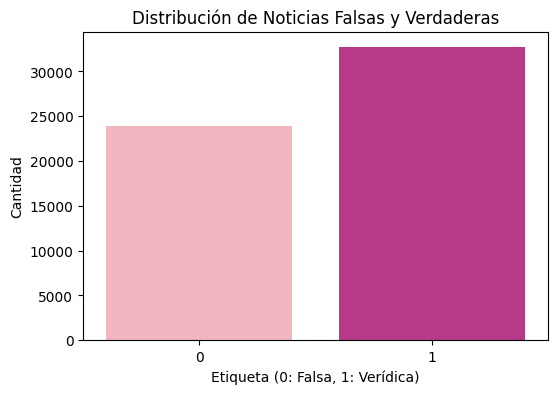

In [44]:
# Distribución de noticias falsas y verdaderas
plt.figure(figsize=(6,4))
sns.countplot(x=df['Label'], palette='RdPu')
plt.title('Distribución de Noticias Falsas y Verdaderas')
plt.xlabel('Etiqueta (0: Falsa, 1: Verídica)')
plt.ylabel('Cantidad')
plt.show()

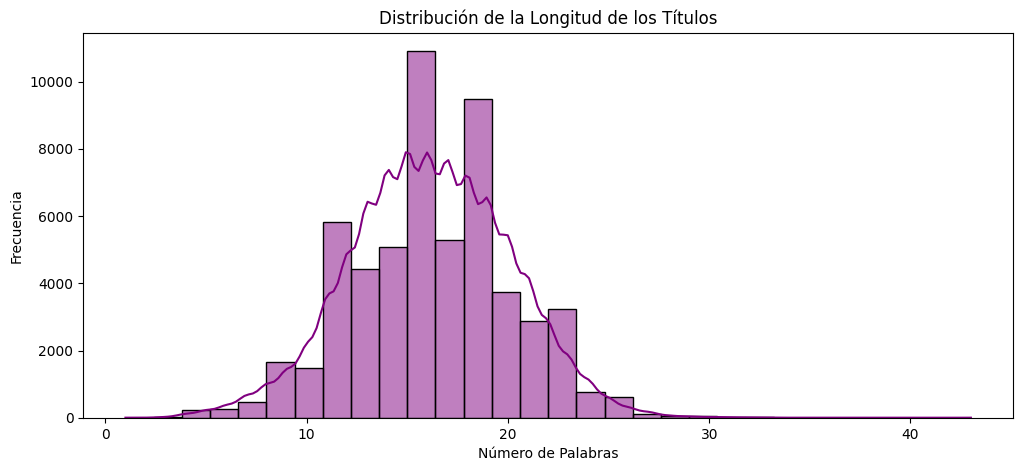

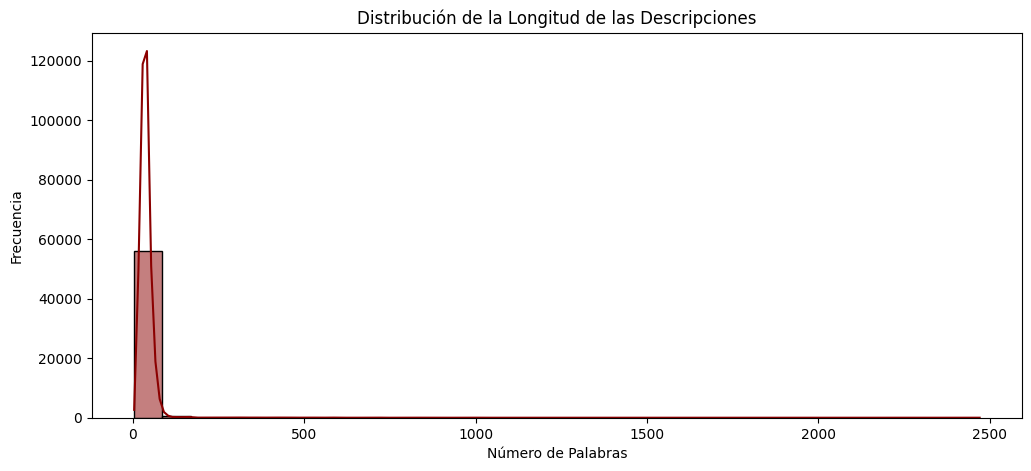

In [45]:
# Longitud del texto en títulos y descripciones
df['Titulo_Longitud'] = df['Titulo'].apply(lambda x: len(str(x).split()))
df['Descripcion_Longitud'] = df['Descripcion'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12, 5))
sns.histplot(df['Titulo_Longitud'], bins=30, kde=True, color='purple')
plt.title('Distribución de la Longitud de los Títulos')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df['Descripcion_Longitud'], bins=30, kde=True, color='darkred')
plt.title('Distribución de la Longitud de las Descripciones')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.show()


/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_55235/2791150674.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Año'], palette='RdPu')


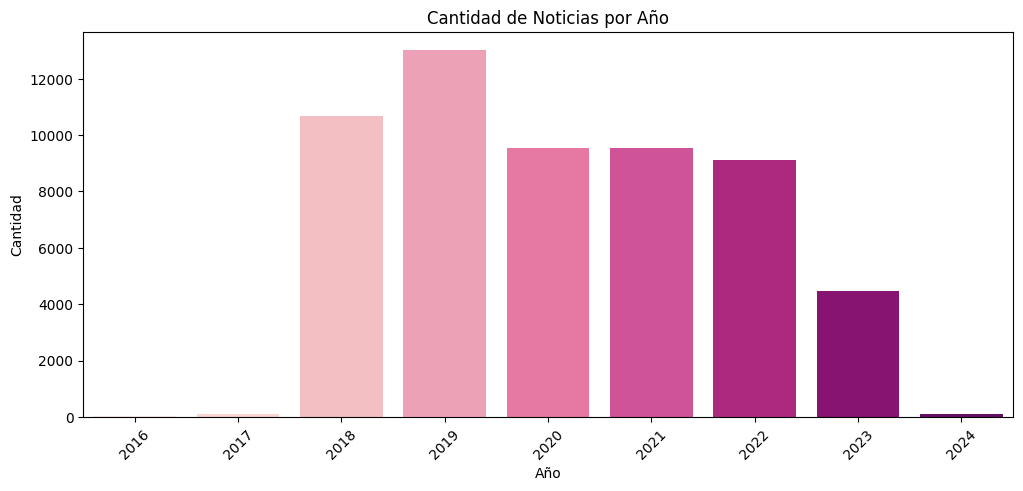

/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_55235/2791150674.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Mes'], palette='RdPu')


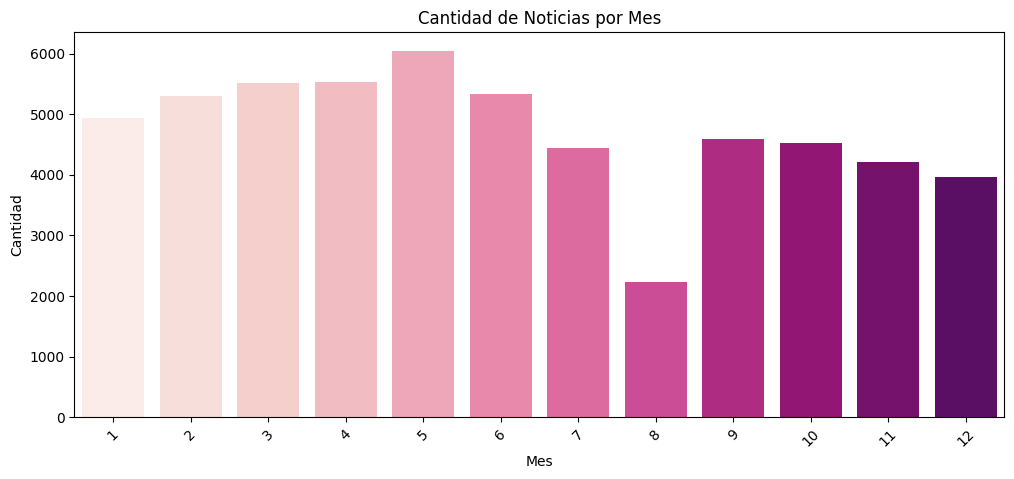

In [46]:
# Análisis de fechas
if pd.api.types.is_datetime64_any_dtype(df['Fecha']):
    df['Año'] = df['Fecha'].dt.year
    df['Mes'] = df['Fecha'].dt.month
    plt.figure(figsize=(12, 5))
    sns.countplot(x=df['Año'], palette='RdPu')
    plt.title('Cantidad de Noticias por Año')
    plt.xlabel('Año')
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.countplot(x=df['Mes'], palette='RdPu')
    plt.title('Cantidad de Noticias por Mes')
    plt.xlabel('Mes')
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.show()


Se construyen nubes de palabras para identiicar cuales son las mas comunes en las noticias

### Nube de palabras

In [47]:
from wordcloud import WordCloud

stop_words = stopwords.words('spanish')
def mostrar_grafico(palabras,stopwords=[]):
    comment_words = ''

    # iterate through the csv file
    for val in palabras:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

In [48]:
train, test = train_test_split(df, test_size=0.2, random_state=33)


---------- Words for Titulos: 0 ----------


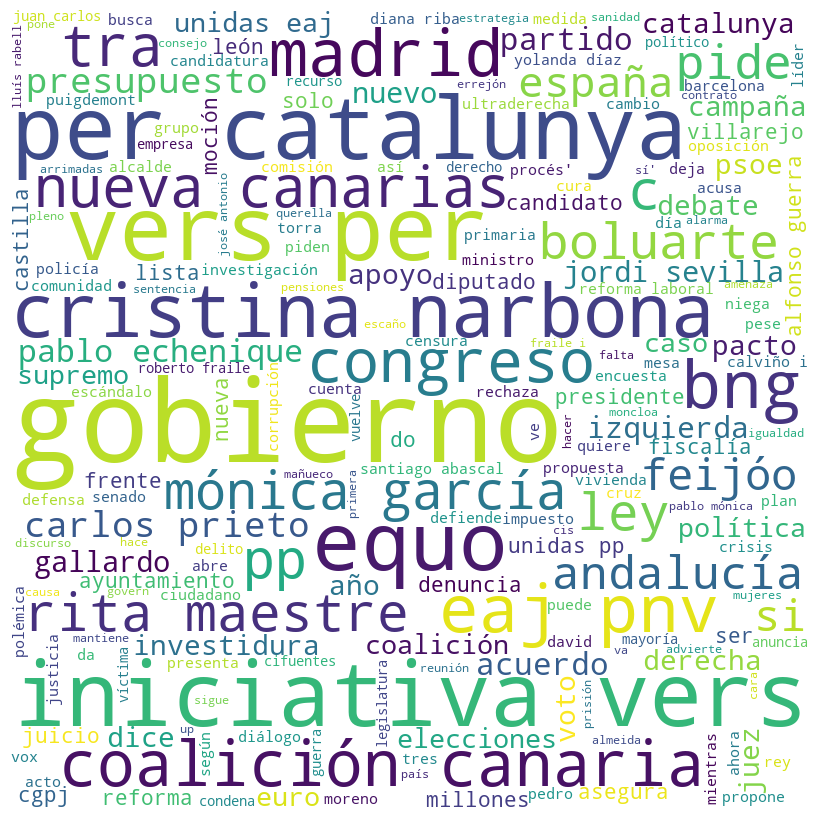

---------- Words for Titulos: 1 ----------


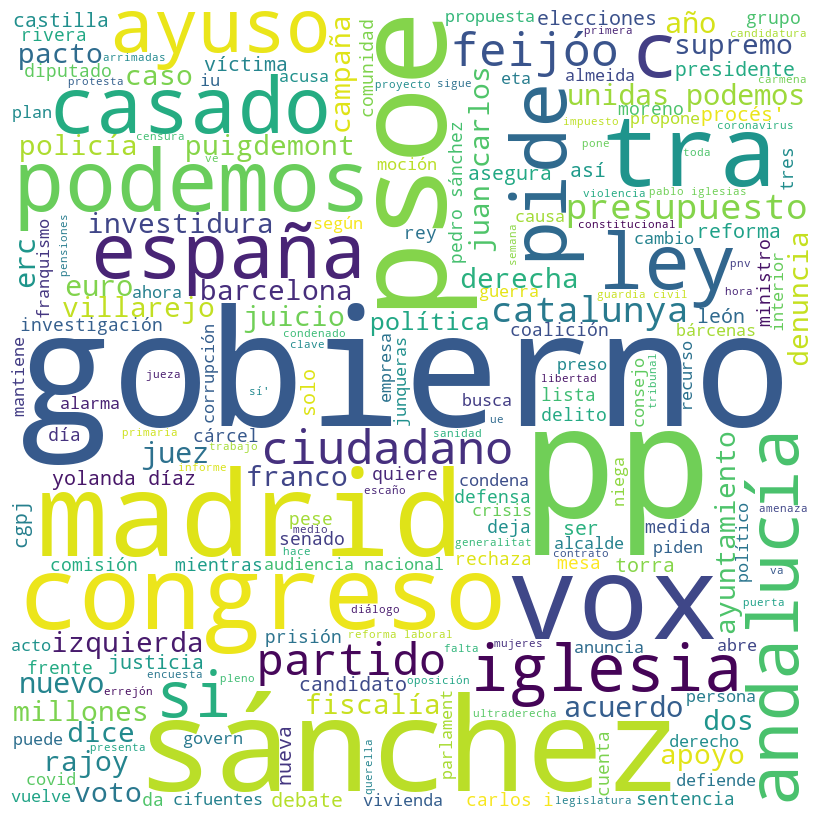

In [49]:
for i in train['Label'].unique():
    print(f'---------- Words for Titulos: {i} ----------')
    mostrar_grafico(train.loc[train['Label']==i,'Titulo'], stopwords=stop_words)

---------- Words for Descripcion: 0 ----------


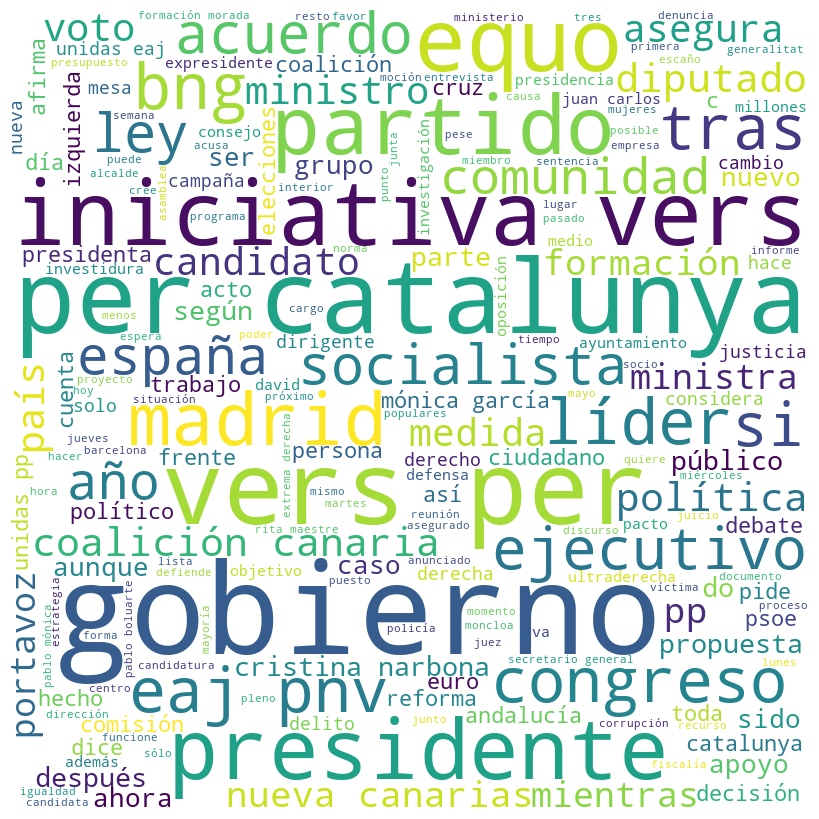

---------- Words for Descripcion: 1 ----------


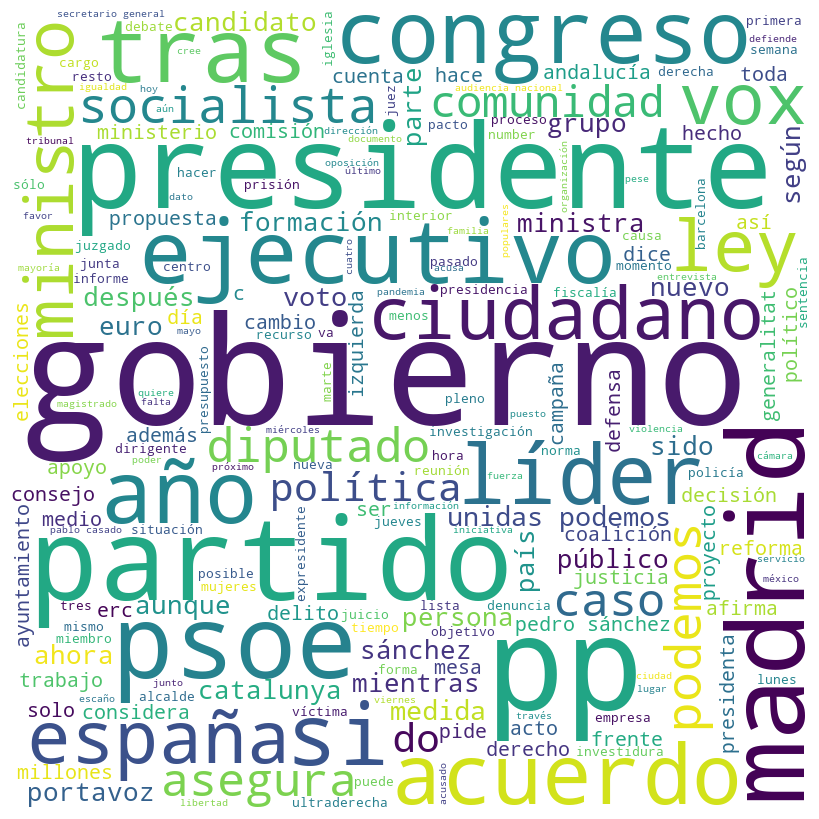

In [50]:
for i in train['Label'].unique():
    print(f'---------- Words for Descripcion: {i} ----------')
    mostrar_grafico(train.loc[train['Label']==i,'Descripcion'], stopwords=stop_words)

In [51]:
df_m = df.copy()
df_m['completo'] = (df['Titulo'] + ' ' + df['Descripcion'])
df_m['words'] = df_m['completo'].apply(word_tokenize)
df_m.head()

,ID,Label,Titulo,Descripcion,Fecha,Titulo_Longitud,Descripcion_Longitud,Año,Mes,completo,words
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-06-02,13,36,2023,6,'The Guardian' va con Sánchez: 'Europa necesit...,"['The, Guardian, ', va, con, Sánchez, :, 'Euro..."
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-10-01,18,545,2023,10,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE..."
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,2022-04-25,14,30,2022,4,El 'Ahora o nunca' de Joan Fuster sobre el est...,"[El, 'Ahora, o, nunca, ', de, Joan, Fuster, so..."
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-01-03,18,20,2022,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","[Iglesias, alienta, a, Yolanda, Díaz, ,, ERC, ..."
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-03-09,10,43,2018,3,Puigdemont: 'No sería ninguna tragedia una rep...,"[Puigdemont, :, 'No, sería, ninguna, tragedia,..."


In [54]:
from sklearn.feature_extraction.text import CountVectorizer

def print_most_frequent_words(texts, n=10):
    # Ensure texts are properly formatted (convert to list and drop NaNs)
    texts = texts.dropna().astype(str).tolist()
    
    # Initialize CountVectorizer with Spanish stop words
    vectorizer = CountVectorizer(stop_words=stop_words)

    # Transform text data into word frequency matrix
    X = vectorizer.fit_transform(texts)

    # Extract feature names (words) and their frequencies
    words = vectorizer.get_feature_names_out()
    sums = X.sum(axis=0)
    
    # Create word-frequency pairs
    word_freq = [(word, sums[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

    # Convert to DataFrame and display top N words
    df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])
    print(df.head(n))

for label in [0, 1]:
    texts_ = df_m[df_m['Label'] == label]['words']  # Extract text column for label
    print(f"Palabras más frecuentes para label {label}:")
    print_most_frequent_words(texts_, n=10)
    print("\n")


Palabras más frecuentes para label 0:
         Word  Frequency
0    gobierno       8274
1   catalunya       6764
2         per       5914
3  iniciativa       5908
4        vers       5550
5        equo       5339
6      madrid       3503
7     partido       3273
8  presidente       3204
9         pnv       3196


Palabras más frecuentes para label 1:
         Word  Frequency
0    gobierno       9945
1          pp       7853
2     podemos       4771
3        psoe       4671
4     sánchez       4638
5      madrid       4554
6     partido       3713
7  presidente       3699
8         vox       3347
9        tras       3324




# 5. Modelos de Clasificacion

## 5.1. Naive Bayes

Este algoritmo fue implementado por Natalia Villegas

Por defecto, se utiliza un clasificador Naïve Bayes de Bernoulli, ideal para tareas de clasificación de texto. El modelo se entrena con el conjunto de datos de entrenamiento y su rendimiento se evalúa utilizando el conjunto de validación.

In [60]:
clf = BernoulliNB()
clf.fit(X_smote, Y_smote)

BernoulliNB()

In [61]:
y_predTrain_BNaive = clf.predict(X_smote)


Resultados con el conjunto de entrenamiento

In [64]:
# Evaluación del con
accuracy = accuracy_score(Y_smote, y_predTrain_BNaive)
precision = precision_score(Y_smote, y_predTrain_BNaive)
recall = recall_score(Y_smote, y_predTrain_BNaive)
f1 = f1_score(Y_smote, y_predTrain_BNaive)
f2 = fbeta_score(Y_smote, y_predTrain_BNaive, beta=2)
roc_auc = roc_auc_score(Y_smote, y_predTrain_BNaive)

print("--- MÉTRICAS DEL ENTRENAMIENTO ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(classification_report(Y_smote, y_predTrain_BNaive))


--- MÉTRICAS DEL ENTRENAMIENTO ---
Accuracy: 0.8798
Precision: 0.8355
Recall: 0.9459
F1 Score: 0.8873
F2 Score: 0.9215
ROC AUC Score: 0.8798
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     22899
           1       0.84      0.95      0.89     22899

    accuracy                           0.88     45798
   macro avg       0.89      0.88      0.88     45798
weighted avg       0.89      0.88      0.88     45798



Estos son los resultados para el conjunto de validación:

In [106]:
y_pred_validation = clf.predict(X_validation)

accuracy = accuracy_score(Y_validation, y_pred_validation)
precision = precision_score(Y_validation, y_pred_validation)
recall = recall_score(Y_validation, y_pred_validation)
f1 = f1_score(Y_validation, y_pred_validation)
f2 = fbeta_score(Y_validation, y_pred_validation, beta=2)
roc_auc = roc_auc_score(Y_validation, y_pred_validation)

print("VALIDACIÓN")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(classification_report(Y_validation, y_pred_validation))

VALIDACIÓN
Accuracy: 0.8488
Precision: 0.8334
Recall: 0.9236
F1 Score: 0.8762
F2 Score: 0.9040
ROC AUC Score: 0.8346
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      7142
           1       0.83      0.92      0.88      9839

    accuracy                           0.85     16981
   macro avg       0.85      0.83      0.84     16981
weighted avg       0.85      0.85      0.85     16981



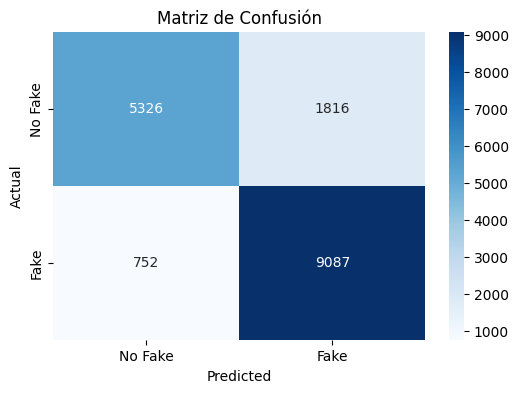

In [108]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, r2_score, confusion_matrix
import seaborn as sns
# Matriz de confusión
conf_matrix = confusion_matrix(Y_validation, y_pred_validation)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fake', 'Fake'], yticklabels=['No Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()


### 5.1.2 Prueba sin el smote

Se intento balancear los datos con Smote y se evidencia que ahora hace una mejor clasificación para las noticias falsas, pero empeora para las verídicas, por lo que se desea evidenciar que sucede al eliminar este balanceo

In [109]:
clf_SinSMOTE = BernoulliNB()
clf_SinSMOTE.fit(X_train, Y_train)

BernoulliNB()

In [110]:
y_predTrainSS_BNaive = clf_SinSMOTE.predict(X_train)


Estos son los resultados para el mismo conjunto de entrenamiento:

In [111]:
# Evaluación del con
accuracy = accuracy_score(Y_train, y_predTrainSS_BNaive)
precision = precision_score(Y_train, y_predTrainSS_BNaive)
recall = recall_score(Y_train, y_predTrainSS_BNaive)
f1 = f1_score(Y_train, y_predTrainSS_BNaive)
f2 = fbeta_score(Y_train, y_predTrainSS_BNaive, beta=2)
roc_auc = roc_auc_score(Y_train, y_predTrainSS_BNaive)

print("--- MÉTRICAS DEL ENTRENAMIENTO ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(classification_report(Y_train, y_predTrain_BNaive))


--- MÉTRICAS DEL ENTRENAMIENTO ---
Accuracy: 0.8838
Precision: 0.8587
Recall: 0.9564
F1 Score: 0.9049
F2 Score: 0.9351
ROC AUC Score: 0.8704
              precision    recall  f1-score   support

           0       0.93      0.78      0.85     16722
           1       0.86      0.96      0.90     22899

    accuracy                           0.88     39621
   macro avg       0.89      0.87      0.88     39621
weighted avg       0.89      0.88      0.88     39621



Estos son los resultados para el conjunto de validacion:

In [112]:
y_pred_validationSS = clf_SinSMOTE.predict(X_validation)

accuracy = accuracy_score(Y_validation, y_pred_validationSS)
precision = precision_score(Y_validation, y_pred_validationSS)
recall = recall_score(Y_validation, y_pred_validationSS)
f1 = f1_score(Y_validation, y_pred_validationSS)
f2 = fbeta_score(Y_validation, y_pred_validationSS, beta=2)
roc_auc = roc_auc_score(Y_validation, y_pred_validationSS)

print("VALIDACIÓN")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(classification_report(Y_validation, y_pred_validationSS))


VALIDACIÓN
Accuracy: 0.8488
Precision: 0.8334
Recall: 0.9236
F1 Score: 0.8762
F2 Score: 0.9040
ROC AUC Score: 0.8346
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      7142
           1       0.83      0.92      0.88      9839

    accuracy                           0.85     16981
   macro avg       0.85      0.83      0.84     16981
weighted avg       0.85      0.85      0.85     16981



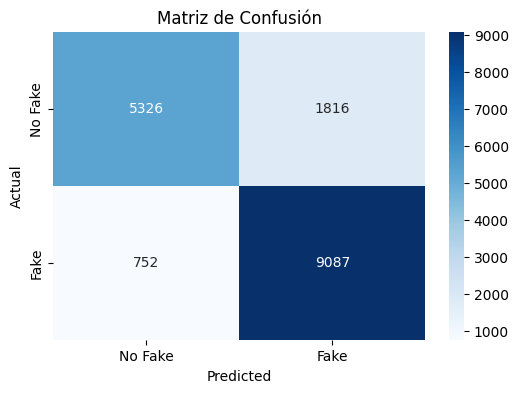

In [113]:
conf_matrix = confusion_matrix(Y_validation, y_pred_validationSS)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fake', 'Fake'], yticklabels=['No Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()


## 5.2. Random Forest

Este algoritmo fue implementado por Carol Florido

Por defecto, se implementa un clasificador RandomForest con los hiperparámetros por defecto, sobre el conjunto de datos SMOTE

In [152]:
# Entrenar modelo Random Forest
model = RandomForestClassifier()
model.fit(X_smote, Y_smote)

RandomForestClassifier()

In [154]:
# Predicciones
y_pred = model.predict(X_smote)



Metricas con los datos de entrenamiento

In [158]:
# Evaluación del modelo
accuracy = accuracy_score(Y_smote, y_pred)
precision = precision_score(Y_smote, y_pred)
recall = recall_score(Y_smote, y_pred)
f1 = f1_score(Y_smote, y_pred)
f2 = fbeta_score(Y_smote, y_pred, beta=2)
roc_auc = roc_auc_score(Y_smote, y_pred)

print("--- MÉTRICAS DEL MODELO ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


--- MÉTRICAS DEL MODELO ---
Accuracy: 1.0000
Precision: 0.9999
Recall: 1.0000
F1 Score: 1.0000
F2 Score: 1.0000
ROC AUC Score: 1.0000


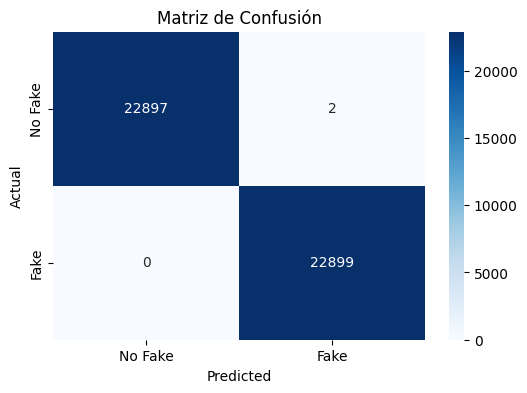

In [160]:
# Matriz de confusión
conf_matrix = confusion_matrix(Y_smote, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fake', 'Fake'], yticklabels=['No Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()


Metricas con los datos de validacion

In [159]:
y_pred_Valitadion = model.predict(X_validation)

accuracy = accuracy_score(Y_validation, y_pred_Valitadion)
precision = precision_score(Y_validation, y_pred_Valitadion)
recall = recall_score(Y_validation, y_pred_Valitadion)
f1 = f1_score(Y_validation, y_pred_Valitadion)
f2 = fbeta_score(Y_validation, y_pred_Valitadion, beta=2)
roc_auc = roc_auc_score(Y_validation, y_pred_Valitadion)

print("VALIDACIÓN")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(classification_report(Y_validation, y_pred_Valitadion))


VALIDACIÓN
Accuracy: 0.8785
Precision: 0.8693
Recall: 0.9301
F1 Score: 0.8987
F2 Score: 0.9172
ROC AUC Score: 0.8687
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      7142
           1       0.87      0.93      0.90      9839

    accuracy                           0.88     16981
   macro avg       0.88      0.87      0.87     16981
weighted avg       0.88      0.88      0.88     16981



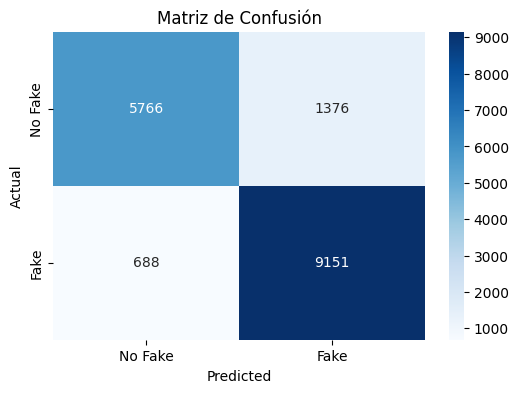

In [161]:
# Matriz de confusión
conf_matrix = confusion_matrix(Y_validation, y_pred_Valitadion)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fake', 'Fake'], yticklabels=['No Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()


### 5.2.1 Seleccion de hiperparametros con Optuna

In [ ]:
import optuna
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, fbeta_score, roc_auc_score, r2_score)
import warnings

# Ignorar warnings de métricas cuando hay clases no representadas en las predicciones
warnings.filterwarnings("ignore", category=UserWarning)

# Vectorización de texto
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Titulo'] + ' ' + df['Descripcion'])
y = df['Label']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Función objetivo para Optuna
def objective(trial):
    """Función objetivo para la optimización de hiperparámetros con Optuna."""
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Definir modelo
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1  # Paralelización
    )

    # Validación cruzada
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    return score  # Se optimiza F1-score

# Configuración de Optuna
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)  # Se aumentan las iteraciones

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("\n--- HIPERPARÁMETROS SELECCIONADOS ---")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Entrenar modelo final con mejores hiperparámetros
model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluación del modelo
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1 Score": f1_score(y_test, y_pred, zero_division=0),
    "F2 Score": fbeta_score(y_test, y_pred, beta=2, zero_division=0),
    "ROC AUC Score": roc_auc_score(y_test, y_pred),
    "R2 Score": r2_score(y_test, y_pred),
}

print("\n--- MÉTRICAS DEL MODELO OPTIMIZADO ---")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


[I 2025-02-21 16:17:58,757] A new study created in memory with name: no-name-c953fe2f-37a9-4d67-bf3e-13ed11903e7d
[I 2025-02-21 16:18:12,450] Trial 0 finished with value: 0.9156673207453018 and parameters: {'n_estimators': 144, 'max_depth': 48, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9156673207453018.
[I 2025-02-21 16:18:14,927] Trial 1 finished with value: 0.8413882950691101 and parameters: {'n_estimators': 89, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9156673207453018.
[I 2025-02-21 16:18:25,859] Trial 2 finished with value: 0.9074871609367652 and parameters: {'n_estimators': 200, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9156673207453018.
[I 2025-02-21 16:18:32,406] Trial 3 finished with value: 0.8561436317969735 and parameters: {'n_estimators': 258, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value:


--- HIPERPARÁMETROS SELECCIONADOS ---
n_estimators: 284
max_depth: 49
min_samples_split: 4
min_samples_leaf: 1

--- MÉTRICAS DEL MODELO OPTIMIZADO ---
Accuracy: 0.9014
Precision: 0.8618
Recall: 0.9879
F1 Score: 0.9206
F2 Score: 0.9598
ROC AUC Score: 0.8854
R2 Score: 0.5958


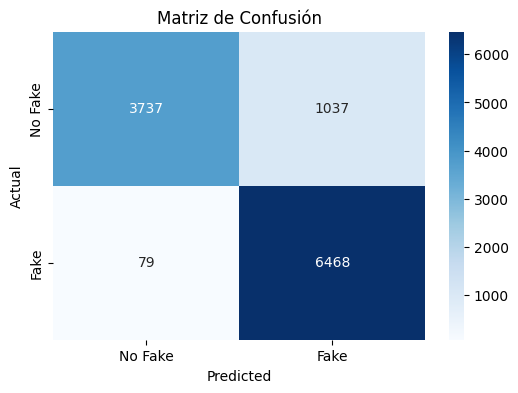

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, r2_score, confusion_matrix
import seaborn as sns
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fake', 'Fake'], yticklabels=['No Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()


In [ ]:

import joblib

# Guardar el modelo entrenado
joblib.dump(model, "modelo_random_forest_Optuna.pkl")


['modelo_random_forest_Optuna.pkl']

## 5.3 KNN

Este algoritmo fue implementado por Martin Vazques

Se reducen las dimensiones analizadas por el algoritmo, con el fin de manejar solo las variables más relevantes para el problema de clasificación

In [143]:
# Sum the occurrences of each n-gram
conteos_smote = X_smote.sum(axis=0)
conteos_smote = pd.Series(conteos_smote.A1, index=tf_idf_vectorizer.get_feature_names_out())

# Identify the 9000 most frequent words
top_9000_conteos_smote = conteos_smote.nlargest(9000).index

# Get the corresponding column indices in the sparse matrix
top_3000_indices = [tf_idf_vectorizer.vocabulary_[word] for word in top_9000_conteos_smote]

# Filter the sparse matrix using column indices
X_smote_knn = X_smote[:, top_3000_indices]
X_validation_knn = X_validation[:, top_3000_indices]

X_smote_knn


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1097279 stored elements and shape (45798, 9000)>

Por defecto, se implementa un KNN con 3 vecinos entrenado sobre los conjuntos de SMOTE

In [144]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh = neigh.fit(X_smote_knn, Y_smote.values.ravel())

A continuación se muestran los resultados para el mismo conjunto de entrenamiento

In [145]:
y_pred_train = neigh.predict(X_smote_knn)


In [146]:
# Evaluación del con
accuracy = accuracy_score(Y_smote, y_pred_train)
precision = precision_score(Y_smote, y_pred_train)
recall = recall_score(Y_smote, y_pred_train)
f1 = f1_score(Y_smote, y_pred_train)
f2 = fbeta_score(Y_smote, y_pred_train, beta=2)
roc_auc = roc_auc_score(Y_smote, y_pred_train)

print("--- MÉTRICAS DEL ENTRENAMIENTO ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(classification_report(Y_smote, y_pred_train))


--- MÉTRICAS DEL ENTRENAMIENTO ---
Accuracy: 0.7694
Precision: 0.8203
Recall: 0.6898
F1 Score: 0.7494
F2 Score: 0.7124
ROC AUC Score: 0.7694
              precision    recall  f1-score   support

           0       0.73      0.85      0.79     22899
           1       0.82      0.69      0.75     22899

    accuracy                           0.77     45798
   macro avg       0.78      0.77      0.77     45798
weighted avg       0.78      0.77      0.77     45798



Resultados con el conjunto de validacion

In [147]:
y_pred_validation = neigh.predict(X_validation_knn)
print("VALIDACIÓN")
print('Accuracy: %.2f' % accuracy_score(Y_validation, y_pred_validation))
print("Precision: {}".format(precision_score(Y_validation, y_pred_validation, average='macro')))
print("Recall: {}".format(recall_score(Y_validation, y_pred_validation, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_validation, y_pred_validation, average='macro')))
print(f"F2 Score: {f2:.4f}".format(fbeta_score(Y_validation, y_pred_validation, beta=2)))
print(f"ROC AUC Score: {roc_auc:.4f}".format(roc_auc_score(Y_validation, y_pred_validation)))
print(classification_report(Y_validation, y_pred_validation))

VALIDACIÓN
Accuracy: 0.52
Precision: 0.5160275215910086
Recall: 0.516441116139547
Puntuación F1: 0.513291683319628
F2 Score: 0.7124
ROC AUC Score: 0.7694
              precision    recall  f1-score   support

           0       0.44      0.51      0.47      7142
           1       0.60      0.52      0.55      9839

    accuracy                           0.52     16981
   macro avg       0.52      0.52      0.51     16981
weighted avg       0.53      0.52      0.52     16981



Ademas, se construye la siguiente matriz de confusión

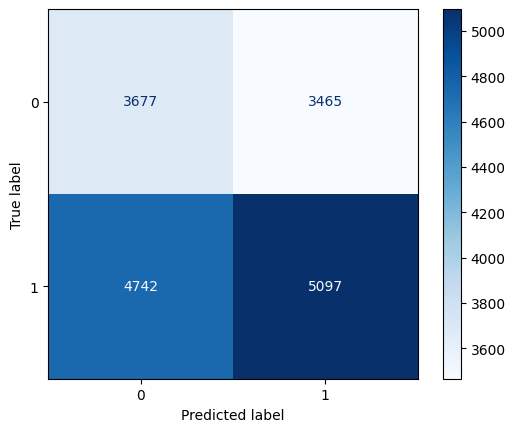

In [148]:
cm = confusion_matrix(Y_validation, y_pred_validation)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

### 5.3.1. Seleccion de hiperparametros

Para mejorar aún más los resultados obtenidos, exploramos los mejores hiperparámetros (n_neighbors y weights) mediante una búsqueda en grilla con 10 particiones. Como métrica de evaluación, utilizamos la precisión, ya que ha sido la más afectada y es prioritaria en el contexto de nuestro problema.

In [149]:
param_grid = {"n_neighbors": [3,5,7], "weights": ['uniform', 'distance']}
neigh = KNeighborsClassifier()
particiones = KFold(n_splits=10, shuffle=True, random_state=0)
mejor_modelo = GridSearchCV(neigh, param_grid, cv=particiones)
mejor_modelo.fit(X_smote_knn, Y_smote.values.ravel())
mejor_modelo.best_params_

{'n_neighbors': 7, 'weights': 'uniform'}

Con los nuevos parámetros, se analizan las métricas tanto en entrenamiento como en validación, con el objetivo de lograr una mejora en el desempeño del modelo sin incurrir en sobreajuste.

In [150]:
knn_final = mejor_modelo.best_estimator_

y_pred_train = knn_final.predict(X_smote_knn)
accuracy = accuracy_score(Y_smote, y_pred_train)
precision = precision_score(Y_smote, y_pred_train)
recall = recall_score(Y_smote, y_pred_train)
f1 = f1_score(Y_smote, y_pred_train)
f2 = fbeta_score(Y_smote, y_pred_train, beta=2)
roc_auc = roc_auc_score(Y_smote, y_pred_train)

print("--- MÉTRICAS DEL ENTRENAMIENTO ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(classification_report(Y_smote, y_pred_train))

y_pred_validation = knn_final.predict(X_validation_knn)
print("VALIDACIÓN")
print('Accuracy: %.2f' % accuracy_score(Y_validation, y_pred_validation))
print("Precision: {}".format(precision_score(Y_validation, y_pred_validation, average='macro')))
print("Recall: {}".format(recall_score(Y_validation, y_pred_validation, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_validation, y_pred_validation, average='macro')))
print(f"F2 Score: {f2:.4f}".format(fbeta_score(Y_validation, y_pred_validation, beta=2)))
print(f"ROC AUC Score: {roc_auc:.4f}".format(roc_auc_score(Y_validation, y_pred_validation)))
print(classification_report(Y_validation, y_pred_validation))

--- MÉTRICAS DEL ENTRENAMIENTO ---
Accuracy: 0.7676
Precision: 0.7831
Recall: 0.7402
F1 Score: 0.7610
F2 Score: 0.7484
ROC AUC Score: 0.7676
              precision    recall  f1-score   support

           0       0.75      0.79      0.77     22899
           1       0.78      0.74      0.76     22899

    accuracy                           0.77     45798
   macro avg       0.77      0.77      0.77     45798
weighted avg       0.77      0.77      0.77     45798

VALIDACIÓN
Accuracy: 0.63
Precision: 0.6192722967701845
Recall: 0.621492318685926
Puntuación F1: 0.6194943405381893
F2 Score: 0.7484
ROC AUC Score: 0.7676
              precision    recall  f1-score   support

           0       0.55      0.60      0.57      7142
           1       0.69      0.64      0.67      9839

    accuracy                           0.63     16981
   macro avg       0.62      0.62      0.62     16981
weighted avg       0.63      0.63      0.63     16981



Adicionalmente, se vuelve a construir la matriz de confusión con el conjunto de validación

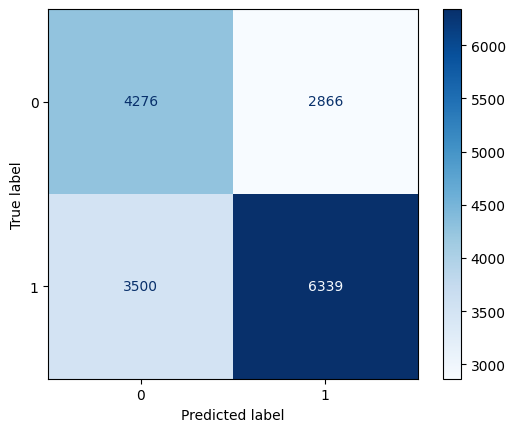

In [151]:
cm = confusion_matrix(Y_validation, y_pred_validation)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_final.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()